<a href="https://colab.research.google.com/github/grace-arina/Skin-Lesion-Detection-Using-Neural-Networks/blob/starter_models/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/drscarlat/melanoma')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gracearina
Your Kaggle Key: ··········


100%|██████████| 5.26G/5.26G [02:03<00:00, 45.7MB/s]


Import Modules

In [3]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB4

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime
import itertools
import os.path
import os
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

%load_ext tensorboard

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [6]:
import funct

In [7]:
train_dir = '/content/melanoma/DermMel/train_sep'
test_dir = '/content/melanoma/DermMel/test/'
val_dir = '/content/melanoma/DermMel/valid'

In [8]:
idg = ImageDataGenerator(rescale=1./255)

train_set = idg.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_set = idg.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_set = idg.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [9]:
# Pulling out images and labels from the image sets for visualizing
train_imgs, train_labels = next(train_set)
val_imgs, val_labels = next(val_set)
test_imgs, test_labels = next(test_set)

In [10]:
print(train_set.class_indices)
print(val_set.class_indices)
print(test_set.class_indices)
for data_batch, labels_batch in train_set:
  print("Train shape:", data_batch.shape)
  print("Train labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in val_set:
  print("Validation shape:", data_batch.shape)
  print("Validation labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in test_set:
  print("Test shape:", data_batch.shape)
  print("Test labels shape:", labels_batch.shape)
  break

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
Train shape: (32, 224, 224, 3)
Train labels shape: (32, 2)
Validation shape: (32, 224, 224, 3)
Validation labels shape: (32, 2)
Test shape: (32, 224, 224, 3)
Test labels shape: (32, 2)


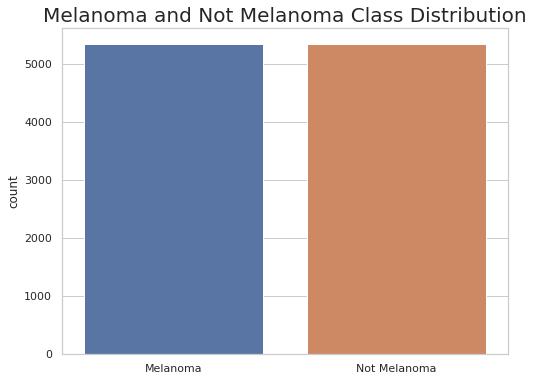

In [11]:
import seaborn as sns

# Creating a series of the training labels and mapping on readable names
class_labels = pd.Series(train_set.labels).map({0: 'Melanoma', 
                                                   1: 'Not Melanoma'})

# Plotting the distribution of the classes
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.countplot(x=class_labels)
ax.set_title('Melanoma and Not Melanoma Class Distribution', 
             fontdict={'fontsize': 20});

In [12]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr[:10], axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

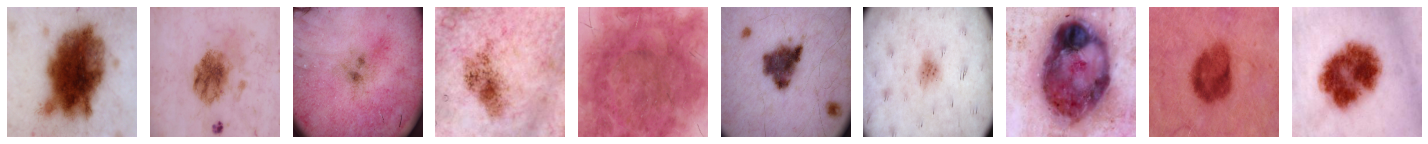

In [13]:
plotImages(train_imgs)
print(train_labels[:10])

### Build Fine-Tuned EfficientNet Model

First Model

In [14]:
# Setting paramaters on early stopping
earlystop = EarlyStopping(monitor='val_acc',
                          patience=15,
                          verbose=1)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [39]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_dataset = test_datagen.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_dataset = test_datagen.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [40]:
effnet_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [41]:
effnet_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [42]:
#Convert the EfficientNetB4 model to a sequential model

effnet_1 = Sequential()
effnet_1.add(effnet_model)
effnet_1.add(layers.Flatten())
effnet_1.add(layers.Dropout(0.5))
effnet_1.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
effnet_1.add(layers.Dropout(0.5))
effnet_1.add(layers.Dense(2, activation='softmax'))

In [43]:
for layer in effnet_model.layers:
  layer.trainable = False

In [44]:
effnet_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 flatten_2 (Flatten)         (None, 87808)             0         
                                                                 
 dropout_4 (Dropout)         (None, 87808)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                5619776   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,293,729
Trainable params: 5,619,906
N

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
effnet_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])


In [46]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/effnet_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [47]:
history_en1 = effnet_1.fit(train_dataset,
                       validation_data=val_dataset,
                       steps_per_epoch=20,
                       validation_steps=val_dataset.n//val_dataset.batch_size,
                       epochs=50,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/50
20/20 [==============================] - 55s 2s/step - loss: 0.9094 - acc: 0.6438 - val_loss: 1.0323 - val_acc: 0.5633
Epoch 2/50
20/20 [==============================] - 58s 3s/step - loss: 0.6702 - acc: 0.7234 - val_loss: 0.6239 - val_acc: 0.7387
Epoch 3/50
20/20 [==============================] - 58s 3s/step - loss: 0.6187 - acc: 0.7734 - val_loss: 0.6063 - val_acc: 0.7607
Epoch 4/50
20/20 [==============================] - 58s 3s/step - loss: 0.5688 - acc: 0.7969 - val_loss: 0.5268 - val_acc: 0.8204
Epoch 5/50
20/20 [==============================] - 41s 2s/step - loss: 0.5536 - acc: 0.8078 - val_loss: 0.5324 - val_acc: 0.8046
Epoch 6/50
20/20 [==============================] - 58s 3s/step - loss: 0.5792 - acc: 0.7984 - val_loss: 0.5509 - val_acc: 0.7962
Epoch 7/50
20/20 [==============================] - 40s 2s/step - loss: 0.5365 - acc: 0.8172 - val_loss: 0.5017 - val_acc: 0.8308
Epoch 8/50
20/20 [==============================] - 57s 3s/step - loss: 0.5392 - acc: 0.81

In [48]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/effnet_1.h5') is False:
  effnet_1.save('/content/drive/MyDrive/Colab Notebooks/models/effnet_1.h5')

In [49]:
effnet_1.evaluate(test_dataset)

112/112 [==============================] - 27s 241ms/step - loss: 0.5124 - acc: 0.8124


[0.5124238133430481, 0.8124122619628906]

In [50]:
pred_en1 = effnet_1.predict(test_dataset, verbose=0)
pred_en1

array([[0.7334135 , 0.26658648],
       [0.59934247, 0.40065753],
       [0.98346925, 0.01653072],
       ...,
       [0.5630984 , 0.43690163],
       [0.06344015, 0.9365598 ],
       [0.4410164 , 0.55898356]], dtype=float32)

[[1152  629]
 [  39 1741]]


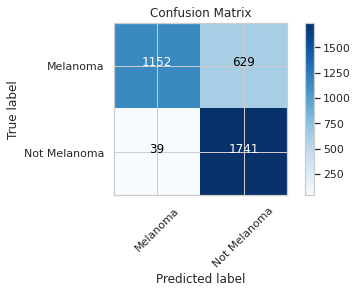

In [51]:
funct.plot_cm(y_true=test_dataset.classes, y_pred=np.argmax(pred_en1, axis=-1), classes=["Melanoma", "Not Melanoma"])

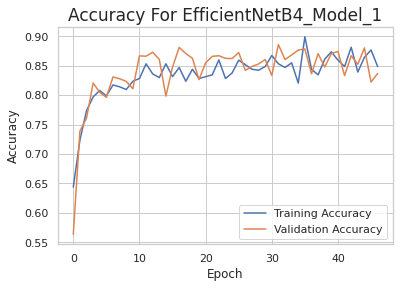

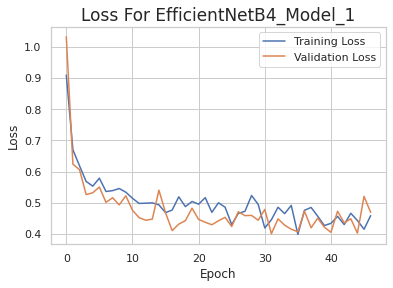

In [53]:
funct.plot_model_metrics(hist=history_en1, label='EfficientNetB4_Model_1')

### Second Model

In [54]:
train_idg = ImageDataGenerator(preprocessing_function=preprocess_input
                               )
val_idg = ImageDataGenerator(preprocessing_function=preprocess_input
                             )

train_gen = train_idg.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_gen = val_idg.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_gen = val_idg.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [55]:
effnet_model2 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [56]:
effnet_2 = Sequential()
effnet_2.add(effnet_model2)
effnet_2.add(layers.Flatten())
effnet_2.add(layers.Dropout(0.5))
effnet_2.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
effnet_2.add(layers.Dropout(0.5))
effnet_2.add(layers.Dense(2, activation='softmax'))

In [57]:
for layer in effnet_model2.layers[:-1]:
  layer.trainable = False

In [58]:
effnet_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 flatten_3 (Flatten)         (None, 87808)             0         
                                                                 
 dropout_6 (Dropout)         (None, 87808)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                5619776   
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,293,729
Trainable params: 5,619,906
N

In [59]:
effnet_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [60]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/effnet_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [61]:
history_en2 = effnet_2.fit(train_gen,
                       validation_data=val_gen,
                       steps_per_epoch=250,
                       epochs=15,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/15
250/250 [==============================] - 96s 337ms/step - loss: 0.8333 - acc: 0.7761 - val_loss: 0.4265 - val_acc: 0.9020
Epoch 2/15
250/250 [==============================] - 82s 329ms/step - loss: 0.5569 - acc: 0.8389 - val_loss: 0.4097 - val_acc: 0.9110
Epoch 3/15
250/250 [==============================] - 82s 328ms/step - loss: 0.5221 - acc: 0.8553 - val_loss: 0.4598 - val_acc: 0.8818
Epoch 4/15
250/250 [==============================] - 83s 333ms/step - loss: 0.4985 - acc: 0.8605 - val_loss: 0.3938 - val_acc: 0.9118
Epoch 5/15
250/250 [==============================] - 82s 327ms/step - loss: 0.5210 - acc: 0.8674 - val_loss: 0.5028 - val_acc: 0.9104
Epoch 6/15
250/250 [==============================] - 82s 329ms/step - loss: 0.5414 - acc: 0.8638 - val_loss: 0.4161 - val_acc: 0.9166
Epoch 7/15
250/250 [==============================] - 82s 329ms/step - loss: 0.5381 - acc: 0.8661 - val_loss: 0.4531 - val_acc: 0.9245
Epoch 8/15
250/250 [==============================] - 8

In [62]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/effnet_2.h5') is False:
  effnet_2.save('/content/drive/MyDrive/Colab Notebooks/models/effnet_2.h5')

In [63]:
effnet_2.evaluate(test_gen)

112/112 [==============================] - 25s 222ms/step - loss: 0.3941 - acc: 0.9096


[0.39406540989875793, 0.9095759391784668]

In [64]:
pred_en2 = effnet_2.predict(test_gen, verbose=0)
pred_en2

array([[9.9958473e-01, 4.1530924e-04],
       [9.9482083e-01, 5.1791626e-03],
       [9.9958795e-01, 4.1211082e-04],
       ...,
       [6.2705970e-01, 3.7294027e-01],
       [1.5365142e-01, 8.4634864e-01],
       [2.8964260e-01, 7.1035737e-01]], dtype=float32)

[[1502  279]
 [  43 1737]]


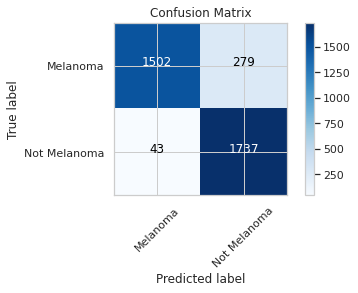

In [65]:
funct.plot_cm(y_true=test_gen.classes, y_pred=np.argmax(pred_en2, axis=-1), classes=["Melanoma", "Not Melanoma"])

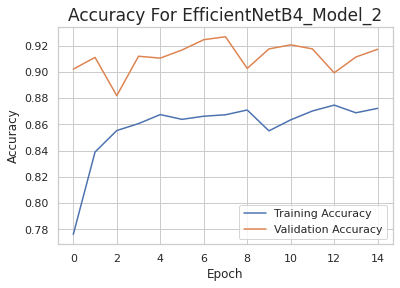

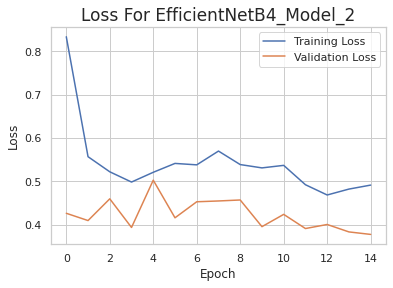

In [66]:
funct.plot_model_metrics(hist=history_en2, label='EfficientNetB4_Model_2')

### Third Model

In [67]:
effnet_model3 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [68]:
effnet_3 = Sequential()
effnet_3.add(effnet_model3)
effnet_3.add(layers.Flatten())
effnet_3.add(layers.Dropout(0.5))
effnet_3.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
effnet_3.add(layers.Dropout(0.5))
effnet_3.add(layers.Dense(2, activation='softmax'))

In [69]:
for layer in effnet_model3.layers[:-3]:
  layer.trainable = False

In [70]:
effnet_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 flatten_4 (Flatten)         (None, 87808)             0         
                                                                 
 dropout_8 (Dropout)         (None, 87808)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                5619776   
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,293,729
Trainable params: 6,426,306
N

In [71]:
effnet_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [72]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/effnet_3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [73]:
history_en3 = effnet_3.fit(train_gen,
                       validation_data=val_gen,
                       steps_per_epoch=100,
                       epochs=50,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/10
100/100 [==============================] - 66s 538ms/step - loss: 1.3398 - acc: 0.7613 - val_loss: 0.6748 - val_acc: 0.8672
Epoch 2/10
100/100 [==============================] - 51s 510ms/step - loss: 0.7260 - acc: 0.8406 - val_loss: 0.6192 - val_acc: 0.8891
Epoch 3/10
100/100 [==============================] - 51s 510ms/step - loss: 0.6548 - acc: 0.8781 - val_loss: 0.5877 - val_acc: 0.8922
Epoch 4/10
100/100 [==============================] - 51s 512ms/step - loss: 0.6360 - acc: 0.8772 - val_loss: 0.5329 - val_acc: 0.9186
Epoch 5/10
100/100 [==============================] - 50s 507ms/step - loss: 0.5896 - acc: 0.8894 - val_loss: 0.5177 - val_acc: 0.9239
Epoch 6/10
100/100 [==============================] - 50s 507ms/step - loss: 0.5331 - acc: 0.9009 - val_loss: 0.4750 - val_acc: 0.9214
Epoch 7/10
100/100 [==============================] - 51s 510ms/step - loss: 0.5294 - acc: 0.9056 - val_loss: 0.4723 - val_acc: 0.9197
Epoch 8/10
100/100 [==============================] - 5

In [74]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/effnet_3.h5') is False:
  effnet_3.save('/content/drive/MyDrive/Colab Notebooks/models/effnet_3.h5')

In [75]:
effnet_3.evaluate(test_gen)

112/112 [==============================] - 25s 221ms/step - loss: 0.4517 - acc: 0.9259


[0.45173969864845276, 0.92586350440979]

In [76]:
pred_en3 = effnet_3.predict(test_gen, verbose=0)
pred_en3

array([[9.9992061e-01, 7.9357415e-05],
       [9.9115282e-01, 8.8471537e-03],
       [9.9999976e-01, 2.5582355e-07],
       ...,
       [5.5990565e-01, 4.4009438e-01],
       [1.0189153e-01, 8.9810848e-01],
       [4.3138629e-01, 5.6861371e-01]], dtype=float32)

[[1562  219]
 [  45 1735]]


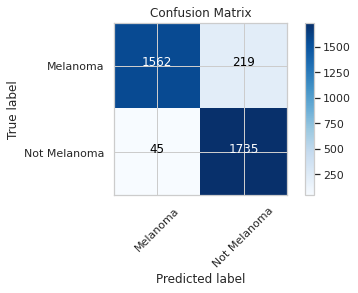

In [77]:
funct.plot_cm(y_true=test_gen.classes, y_pred=np.argmax(pred_en3, axis=-1), classes=["Melanoma", "Not Melanoma"])

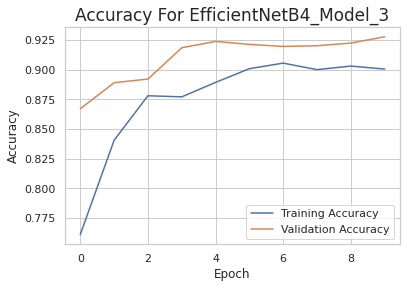

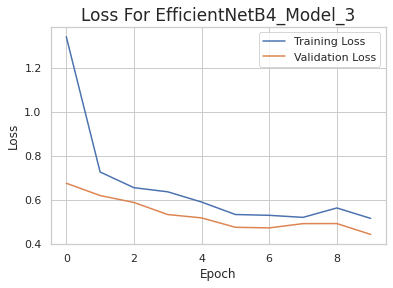

In [78]:
funct.plot_model_metrics(hist=history_en3, label='EfficientNetB4_Model_3')